In [ ]:
"""
Using kaggle here is recommended, these are huge downloads otherwise 
features_train:
https://www.kaggle.com/sarthak1682/models/features_train
labels_train:
https://www.kaggle.com/sarthak1682/models/labels_train
features_val:
https://www.kaggle.com/sarthak1682/models/features_val
labels_val:
https://www.kaggle.com/sarthak1682/models/labels_val
"""

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import gc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

BATCH_SIZE = 256
CHUNK_SIZE = 10000

PATHS = {
    'features_train': "/kaggle/input/all_features_combined/pytorch/default/1/all_features_combined.pt", 
    'features_val': "/kaggle/input/features_val/pytorch/default/1/features_val.pt",
    'labels_train': "/kaggle/input/all_labels_combined/pytorch/default/1/all_labels_combined.pt",
    'labels_val': "/kaggle/input/labels_val/pytorch/default/1/labels_val.pt"
}


Using device: cuda


In [ ]:
def load_data():
    print("Loading data...")

    f_train = torch.load(PATHS['features_train'])
    l_train = torch.load(PATHS['labels_train'])
    f_val = torch.load(PATHS['features_val'])
    l_val = torch.load(PATHS['labels_val'])

    features = torch.cat([f_train, f_val])
    labels = torch.cat([l_train, l_val])

    train_size = len(f_train)
    val_size = len(f_val)

    train_idx = np.arange(train_size)
    val_idx_raw, test_idx_raw = train_test_split(
        np.arange(val_size), test_size=0.5, stratify=l_val.numpy(), random_state=42
    )
    val_idx = train_size + val_idx_raw
    test_idx = train_size + test_idx_raw

    labels_np = labels.numpy()
    unique = np.unique(labels_np)
    if unique.min() != 0 or unique.max() != len(unique) - 1:
        remap = {v: i for i, v in enumerate(unique)}
        labels_np = np.array([remap[y] for y in labels_np])

    del f_train, f_val, l_train, l_val
    gc.collect()
    torch.cuda.empty_cache()

    return features, labels_np, train_idx, val_idx, test_idx, len(unique)

features, labels_np, train_idx, val_idx, test_idx, num_classes = load_data()


In [ ]:
def normalize(features, train_idx):
    print("Normalizing features...")

    dim = features.shape[1]
    mean, var, total = torch.zeros(dim), torch.zeros(dim), 0

    for i in range(0, len(train_idx), CHUNK_SIZE):
        idx = train_idx[i:i+CHUNK_SIZE]
        batch = features[idx]
        mean += batch.sum(0)
        var += (batch ** 2).sum(0)
        total += len(batch)
        del batch
        gc.collect()

    mean /= total
    std = torch.sqrt((var / total) - (mean ** 2) + 1e-8)

    for i in range(0, features.shape[0], CHUNK_SIZE):
        features[i:i+CHUNK_SIZE] = (features[i:i+CHUNK_SIZE] - mean) / std
        if i % (CHUNK_SIZE * 2) == 0:
            gc.collect()

    print("Done")
    return features

features = normalize(features, train_idx)


In [5]:
class LinearProbe(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
    def forward(self, x):
        return self.fc(x)


In [6]:
def evaluate(model, features, labels, idx):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for i in range(0, len(idx), BATCH_SIZE):
            X = features[idx[i:i+BATCH_SIZE]].to(device)
            y = torch.LongTensor(labels[idx[i:i+BATCH_SIZE]]).to(device)
            out = model(X)
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += len(y)
            del X, y, out, pred
            torch.cuda.empty_cache()
    return correct / total

def evaluate_all(model, features, labels, train_idx, val_idx, test_idx):
    results = {
        'train': evaluate(model, features, labels, train_idx),
        'val': evaluate(model, features, labels, val_idx),
        'test': evaluate(model, features, labels, test_idx)
    }
    print("\nFinal Accuracy:")
    for k, v in results.items():
        print(f"{k.capitalize()}: {v:.4f} ({v*100:.2f}%)")
    print(f"Generalization Gap: {(results['train'] - results['test'])*100:.2f}%")
    return results


In [8]:
def train(features, labels, train_idx, val_idx, test_idx, num_classes):
    model = LinearProbe(features.shape[1], num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    best_val, patience = 0, 0
    train_acc_list, val_acc_list = [], []

    for epoch in range(100):
        model.train()
        np.random.shuffle(train_idx)
        correct, total = 0, 0

        for i in range(0, len(train_idx), BATCH_SIZE):
            idx = train_idx[i:i+BATCH_SIZE]
            X = features[idx].to(device)
            y = torch.LongTensor(labels[idx]).to(device)

            optimizer.zero_grad()
            out = model(X)
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()

            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += len(y)

            del X, y, out, pred, loss
            torch.cuda.empty_cache()

        train_acc = correct / total

        if (epoch + 1) % 10 == 0:
            val_acc = evaluate(model, features, labels, val_idx)
            train_acc_list.append(train_acc)
            val_acc_list.append(val_acc)
            print(f"Epoch {epoch+1:3d}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

            if val_acc > best_val:
                best_val = val_acc
                patience = 0
                best_state = model.state_dict()
            else:
                patience += 1
                if patience >= 10:
                    print("Early stopping.")
                    break

    if 'best_state' in locals():
        model.load_state_dict(best_state)

    return model, train_acc_list, val_acc_list

model, train_curve, val_curve = train(features, labels_np, train_idx, val_idx, test_idx, num_classes)


Epoch  10: Train Acc = 0.0308, Val Acc = 0.0266
Epoch  20: Train Acc = 0.0359, Val Acc = 0.0272
Epoch  30: Train Acc = 0.0392, Val Acc = 0.0308
Epoch  40: Train Acc = 0.0414, Val Acc = 0.0316
Epoch  50: Train Acc = 0.0434, Val Acc = 0.0311
Epoch  60: Train Acc = 0.0449, Val Acc = 0.0314
Epoch  70: Train Acc = 0.0460, Val Acc = 0.0332
Epoch  80: Train Acc = 0.0475, Val Acc = 0.0338
Epoch  90: Train Acc = 0.0486, Val Acc = 0.0341
Epoch 100: Train Acc = 0.0494, Val Acc = 0.0348


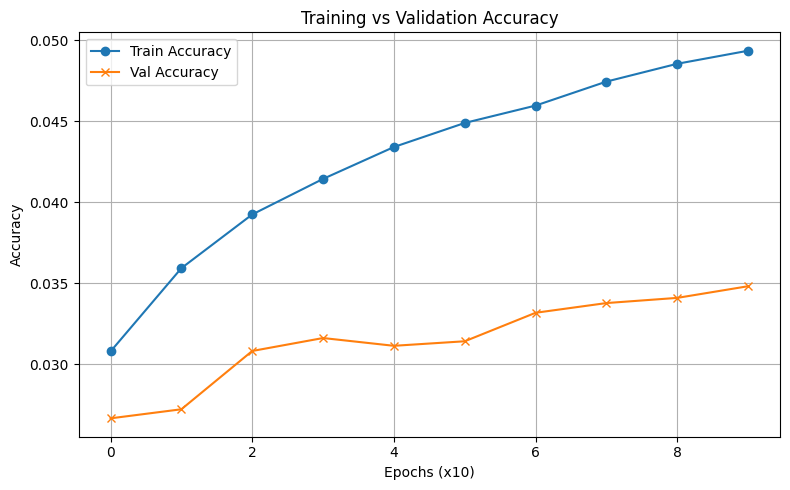

In [9]:
def plot_curves(train_acc_list, val_acc_list):
    plt.figure(figsize=(8, 5))
    plt.plot(train_acc_list, label='Train Accuracy', marker='o')
    plt.plot(val_acc_list, label='Val Accuracy', marker='x')
    plt.xlabel('Epochs (x10)')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_curves(train_curve, val_curve)


In [10]:
results = evaluate_all(model, features, labels_np, train_idx, val_idx, test_idx)

torch.save({
    'results': results,
    'num_classes': num_classes,
    'feature_dim': features.shape[1],
    'data_sizes': {
        'train': len(train_idx),
        'val': len(val_idx),
        'test': len(test_idx)
    }
}, 'features_probe_results.pt')

print("Saved results to 'features_probe_results.pt'")



Final Accuracy:
Train: 0.0520 (5.20%)
Val: 0.0348 (3.48%)
Test: 0.0331 (3.31%)
Generalization Gap: 1.88%
Saved results to 'features_probe_results.pt'
